<font size = '5'> <center>**Logistic Regression using Gradient Descent and Maximum Likelihood Estimation**</center> </font>

In this notebook, I have used two different techniques to built a Logistic Regression model from scratch for classification. The first method is by using gradient descent. In this method, the model architecture is very similar to a neural network. The second method used is the maximum likelihood estimation. In this method we will find the best fitting parameters by using a built in optimization function. 

In [1]:
#load the libraries
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.io import loadmat
import scipy.optimize as opt
from scipy import stats

The dataset I will be using for this tutorial is a dataset I ran accross while doing the <a href = "http://www.cns.nyu.edu/~eero/math-tools19/"> "Mathematical Tools for Neural and Cognitive Science" </a> course. This is a good introductive course if you want to learning statistical and machine learning techniques.

I will be using the fisher dataset from homework 5. The dataset contains two classes. I will be calling one class the category 1 (represented by 1's) and the other category 2 (represented by 0's). There are 70 samples from each category and each sample has two input variables (represented in x and y axes in Figure 1). 

First let's load the data and organize them.

In [25]:
#import current directory
current_dir = os.getcwd()

#data directory
data_dir = current_dir + '\\data'

#load dataset
data = loadmat(data_dir + '\\fisherdata.mat')

#the two categories of data
cat1 = data['data1']
cat2 = data['data2']

#create the outcome variables for the two categories. cateogiry 1 has an outcome var of 1 and cat 2 has an outcome var of 0
cat1_y = np.ones([len(cat1), 1])
cat2_y = np.zeros([len(cat2), 1])

#combine the two datasets
dataset1 = np.append(cat1, cat1_y, 1)
dataset2 = np.append(cat2, cat2_y, 1)

#make one datasets and shuffle the dataset with a random seed = 1
data = np.vstack([dataset1, dataset2])
np.random.seed(1)
np.random.shuffle(data)

#let's print the data matrix to see what it looks like
print('The data matrix\n')
print(data[:10, :])

#print the number of samples
print('\nThe number of samples is: ', len(data))

The data matrix

[[-0.58225834 -0.33721397  1.        ]
 [ 0.35068347 -0.74906443  1.        ]
 [ 2.3963429   0.09370877  1.        ]
 [ 0.24937456  1.62914414  0.        ]
 [-1.6676351  -0.64697267  1.        ]
 [ 1.04836595  1.37301392  0.        ]
 [ 0.34612302 -0.74578621  1.        ]
 [-1.18120618 -0.62222487  1.        ]
 [ 0.47304268  0.61219905  1.        ]
 [ 2.50027191  0.1570426   0.        ]]

The number of samples is:  140


So the columns of the data matrix represents the input variable 1, input variable 2 and the output category respectively. The rows of the data matrix represent each observation. We cans see there are 140 samples and also the data is mixed.

Below are some utility functions to make predictions and plot data once we finish creating our model.

In [26]:
#function to plot 
def plot_results(w, b, X, Y, Y_pred, title = None, figsize = (10, 7), color_code = False):
    
    x_vals = np.arange(np.min(X), np.max(X), 0.1)
    y_vals = (- w[0] * x_vals - b)/ w[1]
    
    y_min = np.min(X[:, 1])
    y_max = np.max(X[:, 1])
    
    #plot figure    
    plt.figure(figsize = figsize)
    
    for i in range(len(X)):
        
        if (Y_pred[i] == Y[i]) and (Y[i] == 1):
            
            plt.scatter(X[i, 0], X[i, 1], s = 50, color = 'r')
            
        if (Y_pred[i] == Y[i]) and (Y[i] == 0):
            
            plt.scatter(X[i, 0], X[i, 1], s = 50, color = 'b')
            
        if (Y_pred[i] != Y[i]) and (Y[i] == 1):
            
            plt.scatter(X[i, 0], X[i, 1], s = 50, facecolor = 'None', edgecolor = 'r')
            
        if (Y_pred[i] != Y[i]) and (Y[i] == 0):
            
            plt.scatter(X[i, 0], X[i, 1], s = 50, facecolor = 'None', edgecolor = 'b')
    
    if title:
        plt.title(title)
        
    plt.plot(x_vals, y_vals, color = 'k', markersize = '20', linestyle = '--')
    
    if color_code:
        
        x = np.arange(np.min(X), np.max(X), 0.1)
        y = (-w[0] * x - b)/w[1]
        plt.fill_between(x, y - 3, y, alpha = 0.2, color = 'r')
        plt.fill_between(x, y + 3, y, alpha = 0.2, color = 'b')

    plt.xlim(np.min(X[:, 0]) - 0.5, np.max(X[:, 0]) + 0.5)
    plt.ylim(np.min(X[:, 1]) - 0.5, np.max(X[:, 1]) + 0.5)
    plt.show()    
    

In [27]:
def plot_sigmoid(w, b, X, Y, Y_pred, title = None, figsize = (10, 7)):
           
    #calculate z
    z = X @ w.T + b
    
    #xmin and x max values
    z_min = np.min(z)
    z_max = np.max(z)
    z_vals = np.arange(z_min, z_max, 0.1)
    
    #calcualte sigmoid
    a = sigmoid(z_vals)
    
    #plot sigmoid
    plt.figure(figsize = (figsize))
    plt.plot(z_vals, a, color = 'k', markersize = 10)
    
    for i in range(len(X)):
        
        if (Y_pred[i] == Y[i]) and (Y[i] == 1):
            
            plt.scatter(z[i], Y_pred[i], s = 50, color = 'r', alpha = 0.2)
            
        if (Y_pred[i] == Y[i]) and (Y[i] == 0):
            
            plt.scatter(z[i], Y_pred[i], s = 50, color = 'b', alpha = 0.2)
            
        if (Y_pred[i] != Y[i]) and (Y[i] == 1):
            
            plt.scatter(z[i], Y_pred[i], s = 50, facecolor = 'None', edgecolor = 'r')
            
        if (Y_pred[i] != Y[i]) and (Y[i] == 0):
            
            plt.scatter(z[i], Y_pred[i], s = 50, facecolor = 'None', edgecolor = 'b')
        
    if title:
        plt.title(title)
    
    plt.show()

In [28]:
#funciton to make predictions
def predict(w, b, X, Y):
    
    #calculate the y predictions
    y_hat,_ = forward_propagation(w, b, X, Y)
    
    #append the values
    y_pred = []
    
    #count correct 
    count = 0
    
    for y in range(len(y_hat)):
        
        #make prediction
        prediction = 1.0 if y_hat[y] > 0.5 else 0.0
        y_pred.append(prediction)
        
        if prediction == int(Y[y]):
            count += 1
            
        
    #print prediction accuracy
    print('Prediction accuracy is {} '.format(np.round(count/len(Y)*100), 5), '%')    
    
    return y_pred

Now let's visualize the dataset

- The category 1 (represented by 1's) is in red
- The category 2 (represented by 0's) is in blue
- The x axis represents the input variable 1
- The y axis represents the input variable 2

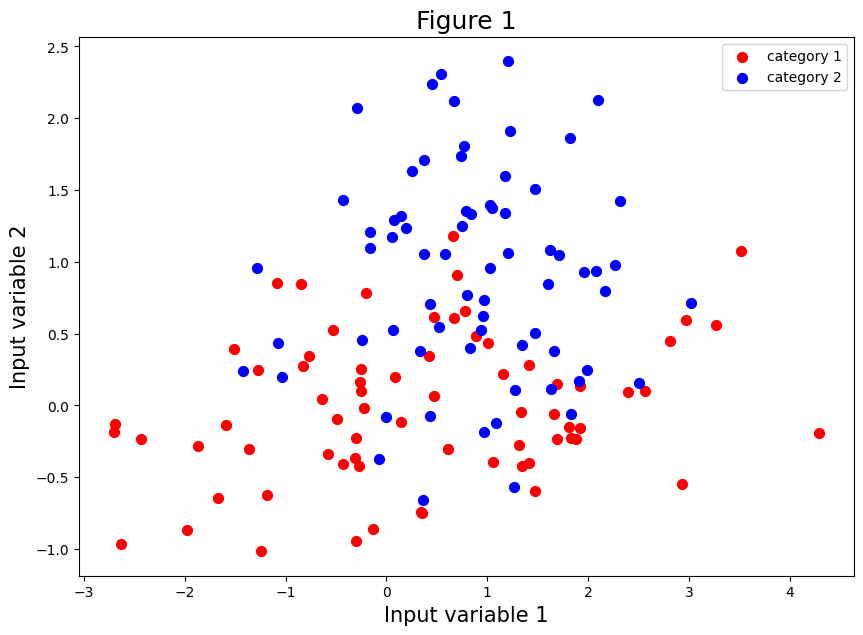

In [29]:
#plot the data
plt.figure(figsize = (10, 7))
plt.scatter(data[data[:, 2] == 1][:, 0], data[data[:, 2] == 1][:, 1], s = 50, color = 'r', label = 'category 1')
plt.scatter(data[data[:, 2] == 0][:, 0], data[data[:, 2] == 0][:, 1], s = 50, color = 'b', label = 'category 2')
plt.title('Figure 1', fontsize = 18)
plt.xlabel('Input variable 1', fontsize = 15)
plt.ylabel('Input variable 2', fontsize = 15)
plt.legend()
plt.show()

So the goal in this tutorial is to use an algorithm (Logistic Regression) to find patterns in this dataset and classify the data to either red or blue categories. Since we already know these categories we can judge how good our model is by evaluating the number of correctly classified data points.

<u>**Logistic Regression using gradient descent**</u>

Logistic Regression (LR) is a very basic but powerful supervised machine learning algorithm used for classification. Here we are implementing LR using numpy. The architecture we are using to build the LR model in this section is very similar to a neural network. If you not familar with neural networks you can also check this <a href = "https://github.com/kaneelgit/ML-DL-Algorithms/blob/main/Hello%20World%20of%20Deep%20Learning.ipynb"> notebook </a> for more information.

#![title](./data/Architecture.png "ShowMyImage") 

Above is an image that represents how our model make predictions. First we input our data (input variable 1 and input variable 2) to our model. Here we use three parameters (W1, W2 and b) to get a weighted sum for our input data. (Note that the number of parameters depend on the size of the input variables. Since we have two inputs we have one weight for each input and a constant making it a total of three variables) The parameters W1 and W2 represents their influence on our final outcome variable. For example if the input variable 1 is not relavent to our final outcome, then the weight of the input variable 1 (W1 in this case) will be close to zero. In other words, input variable 2 will have more influence towards our final prediction. 

Once we have a weighted sum, we need to find the category for each weighted sum. Here we have two categories, where category 1 is represented by 1's and category 2 is represented by 0's. So next we need to map our weighted sum to either 1 or 0. In order to do this we need to find a function that maps input values to 0 or 1. We can achieve this by the sigmoid activation function (equation 1). (Note that there are other functions such as tanh, relu, leaky relu used in other deep learning techniques, but in logistic regression, it is commonplace to use the sigmoid activation function). 

$$ f(z) = \frac{1}{1 + e^{-z}}\;\;\;->\;equation\;1 $$

$$ where\;in\;our\;example,\;z=w_1.input_1+w_2.input_2+b  $$
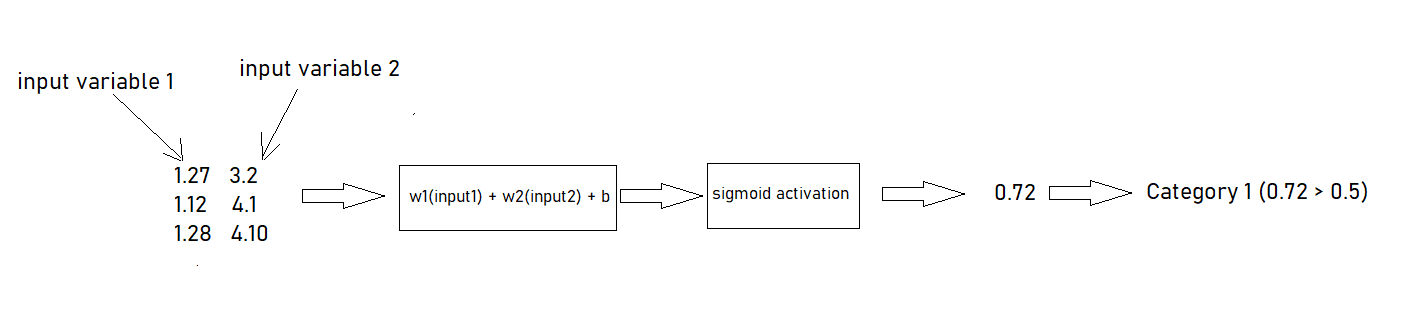

#![title](./data/logistic_curve.png "ShowMyImage") 
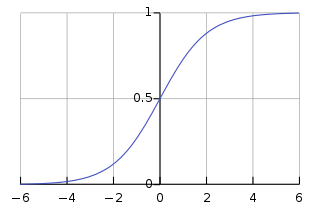

The image above is the output of a sigmoid function. In the x axis we have the input (z) to the sigmoid activation function. The output is a value between 0 and 1. So we can categorize our data by assigning them to their categories based on the value. For example, if we get a 0.56 since the value is greater than 0.5 we assign that sample to the cateogory 1. (similarly we assign all inputs that outputs values less than 0.5 to 0). 

Now let's create a function to define the sigmoid activation.

In [7]:
#sigmoid function
def sigmoid(z):
    """"
    this function takes in the z value and returns it's activation value (between 0 and 1). This also works similarly
    for an input array.
    """
    return 1/(1 + np.exp(-z))

Now let's create a function that generates the forward propagation. 

This function takes the parameter values (w1, w2 and b), the inputs (inp variable 1 and inp variable 2) and the output categories of each input variable. Then it weights the input variables based on the parameters and use the sigmoid activation function to generate a value between 0 and 1.

We will also create a function that initialize our parameter values. We will initialize our w1 and w2 parameters as a random value and the b parameter as zero.

In [8]:
def forward_propagation(w, b, X, Y):
    
    #calculate z
    z = X @ w.T + b
    
    #calculate the activation using the sigmoid function
    y_hat = sigmoid(z)
    
    #calculate the cost 
    cost = calculate_cost(Y, y_hat)
    
    return y_hat, cost

#initialize the parameters
def initialize_parameters():
    
    np.random.seed(1)
    w = np.random.normal([2, 1])
    b = 0
    
    return w, b


After making the predictions we will have to create a function to check how good our predictions were. We call this the loss or cost function and in this case we are using the following loss function.

$$ J(\hat{y}, y) = \frac{1}{m} \sum_{i = 1}^{m} -y^{i}.log{\hat{y}} - (1 - y).log(1 - \hat{y})$$

Here m is the number of samples, $\hat{y}$ is the predicted y value from the model and $y$ is the real categorical value (0 or 1). Here, we simply calculate the difference between our predicted value and the real value for all samples and add them up. If our model is predicting ideally (for example if our model output $\hat{y}$ is 1), then our loss is going to be zero. This means our model is performing well. 

Example scenario where our model outputs $\hat{y} = 0.99$ when our real $y = 1$

$$ loss = -1.log(0.99) - (1 - 1). log(1 - 0.99) = +0.0043648054$$

So we get very low positive loss value. Conversely, if our model predicts 0 instead of 0.99, then the loss value increases.

Now let's define the loss/cost function.

In [9]:
#cost function
def calculate_cost(y_true, y_pred):
    
    #length of the predictions
    m = len(y_true)
    
    #calculate cost
    cost = np.sum(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))
    cost = cost/m
    
    return cost

Now that we have initialized our parameters and defined our forward propagation, let's check how well our model makes predictions.

In [10]:
#get X and Y data
X = data[:, :2]
Y = data[:, 2]

#first initialize our parameters
w, b = initialize_parameters()

#calculate forward propagation to get predictions
y_pred, cost = forward_propagation(w, b, X, Y)

#lets find our accuracy using the predict utility function we created 
y_preds = predict(w, b, X, Y)

#print cost
print('Cost: ', np.round(cost, 4))

Prediction accuracy is 35.0  %
Cost:  2.8406


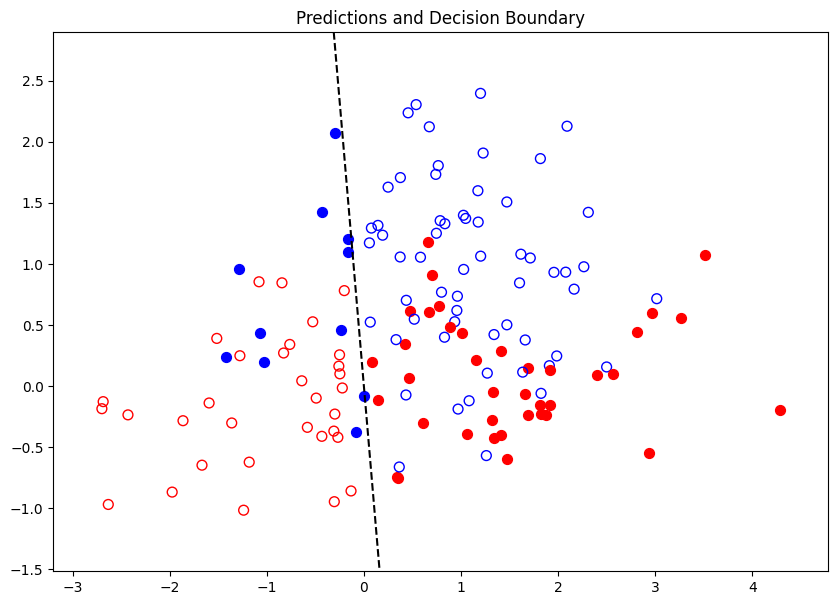

In [11]:
plot_results(w, b, X, Y, y_preds, 'Predictions and Decision Boundary')

The figure above shows the predictions of our algorithm.

- The solid red dots represent data points from category 1 correctly classified as category 1.
- Whereas the open red dots represents data points from category 1 incorrectly classified as category 2.
- The solid blue dots represent data points from category 2 correctly classified as category 2.
- Whereas the open blue dots represents data points from category 2 incorrectly classified as category 1.
- The dashed black line represents the decision boundary in logistic regression. The dashed line is formed by using the parameters initialized by our "initialize_parameters" function.

The prediction accuracy generated by our forward propagation is 35% and if we look at the plot we can see that the model is not doing a good job at classifying the two cateogories. This is because we have initiated our parameters randomly. In order to find the best fit for the data now we have to find the optimal values. We do this by an algorithm called gradient descent. 

**Gradient Descent**

In gradient descent we are basically calculating how our parameters change with the loss function. The goal of the gradient descent algorithm is to find the parameter values that gives the minimum loss value. Mathematically, we do this by calculating how the parameters change with respect to the loss function.

$ J(\hat{y}, y) = \frac{1}{m} \sum_{i = 1}^{m} -y^{i}.log{\hat{y}} - (1 - y).log(1 - \hat{y})$

In order to do this we have to calculate the following gradients. 

<font size = 3> $\frac{dJ}{dw_1},\;\frac{dJ}{dw_2},\;\frac{dJ}{db}$ </font>
    
We can use the chain rule to find these derivatives.
    
<font size = 3> $\frac{dJ}{dw_1} = \frac{dJ}{d\hat{y}} . \frac{d\hat{y}}{dz} . \frac{dz}{dw_1}$ 
    
$\frac{dJ}{dw_2} = \frac{dJ}{d\hat{y}} . \frac{d\hat{y}}{dz} . \frac{dz}{dw_2}$ <br><br>    
    
$\frac{dJ}{db} = \frac{dJ}{d\hat{y}} . \frac{d\hat{y}}{dz} . \frac{dz}{db}$ </font>

So we have to now find the derivative of J w.r.t y and the derivative of y w.r.t z and the derivative z w.r.t each parameter. Then we get the following equations.
    
$\frac{dJ}{dw_1} = \frac{1}{m} \sum_{i}^{m} (\hat{y} - y) . x_1$

$\frac{dJ}{dw_2} = \frac{1}{m} \sum_{i}^{m} (\hat{y} - y) . x_2$

$\frac{dJ}{dw_1} = \frac{1}{m} \sum_{i}^{m} (\hat{y} - y)$

The goal for us is to find the minimum of the loss function. So the derivatives of the parameters gives us the direction we should go in order to get to this minimum. So we have to subtract this derivative value from our current estimate. Before subtracting, we first multiply the derivative by a constant value, which is called the learning rate. This learning rate ($\alpha$) is a hyperparameter which we can change to make our algorithm run faster. We can update our parameters with the three equations below.

$w1 = w1 - \alpha . \frac{dJ}{dw_1}$

$w2 = w2 - \alpha . \frac{dj}{dw_2}$

$b = b - \alpha . \frac{dj}{db}$

Usually we do this until the cost is no longer reducing or we keep running the algorithm for a certain number of iterations.

Now let's create the functions to calculate the gradients and optimize parameters.

In [12]:
#back propagation to find the optimal parameter values   
def backward_propagation(y_pred, Y, X):
    
    #calculate m
    m = len(Y)
    
    #calculate the derivatives
    dw = 1/m * ((y_pred - Y) @ X)
    db = 1/m * np.sum(y_pred - Y)
    
    return dw, db

In [13]:
#find the optimal parameter values
def optimize_parameters(X, Y, learning_rate = 0.01, num_its = 1000):
    
    #append values
    costs, w1, w2, constant = [], [], [], []
    
    
    #initialize parameters
    w, b = initialize_parameters()
    
    for i in range(num_its):
        
        #propagate forward
        y_hat, cost = forward_propagation(w, b, X, Y)
        
        #propagate backwards
        dw, db = backward_propagation(y_hat, Y, X)
        
        #collect the parameters
        costs.append(cost)
        w1.append(w[0])
        w2.append(w[1])
        constant.append(b)
        
        #update weights
        w = w - learning_rate * dw
        b = b - learning_rate * db
                
        #print cost and prediction accuracy
        if i % 500 == 0:
            
            print('------\n')
            print('After iteration {}'.format(i))
            print('Cost is ', cost)
            #find accuracy and predicted values
            y_preds = predict(w, b, X, Y)
            #plot results
            plot_results(w, b, X, Y, y_preds, 'Predictions and Decision Boundary', (4, 2))
            #plot_sigmoid(w, b, X, Y, y_preds, 'Sigmoid function and predictions', (4, 2))
                        
    return w, b, costs, w1, w2, constant

Now we have everything to train the model. Let's use the "optimize_parameters" function to train the model.

------

After iteration 0
Cost is  2.840599474487581
Prediction accuracy is 35.0  %


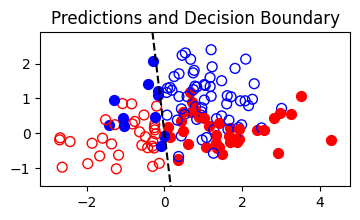

------

After iteration 500
Cost is  1.3934511227619046
Prediction accuracy is 41.0  %


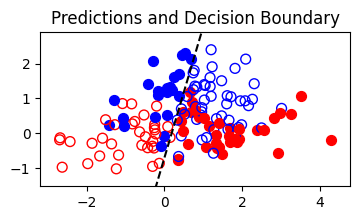

------

After iteration 1000
Cost is  0.7366564118205449
Prediction accuracy is 56.0  %


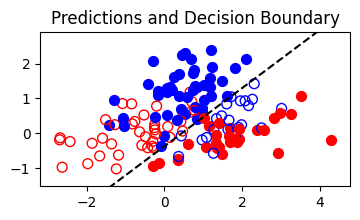

------

After iteration 1500
Cost is  0.5771960076976667
Prediction accuracy is 68.0  %


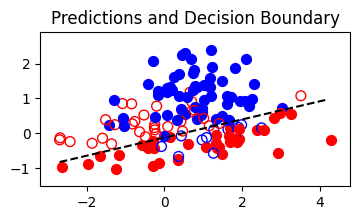

------

After iteration 2000
Cost is  0.530724668497045
Prediction accuracy is 71.0  %


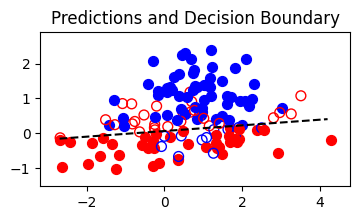

------

After iteration 2500
Cost is  0.5091947220536014
Prediction accuracy is 74.0  %


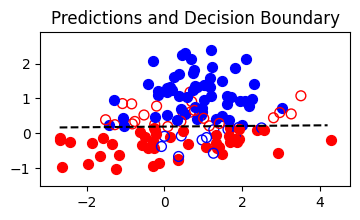

------

After iteration 3000
Cost is  0.49705888143574434
Prediction accuracy is 76.0  %


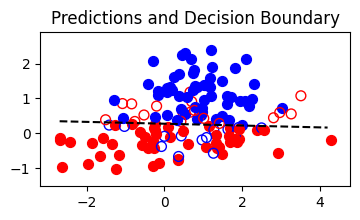

------

After iteration 3500
Cost is  0.48950170440404717
Prediction accuracy is 78.0  %


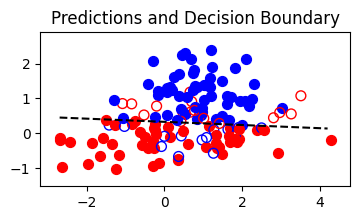

------

After iteration 4000
Cost is  0.4844539209269412
Prediction accuracy is 78.0  %


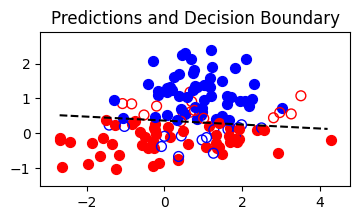

------

After iteration 4500
Cost is  0.4809039581384259
Prediction accuracy is 78.0  %


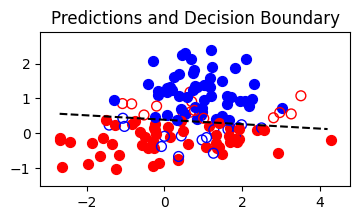

In [14]:
#run the algorith for 5000 iterations

#get X and Y data
X = data[:, :2]
Y = data[:, 2]

w, b, costs, w1, w2, constant = optimize_parameters(X, Y, learning_rate = 0.005, num_its = 5000)

In [15]:
#find accuracy and predicted values
y_preds = predict(w, b, X, Y)

Prediction accuracy is 77.0  %


When we run the function, now we can see how our model changes the parameters and finally reach to the best values. We can also see that the accuracy is increasing and the cost is decreasing with iterations. This shows that our model is learning. Finally, after 5000 iterations the model reaches an accuracy of 77% and a cost of 0.48. We can plot the results now and see how it has changed from the previous time we plotted.

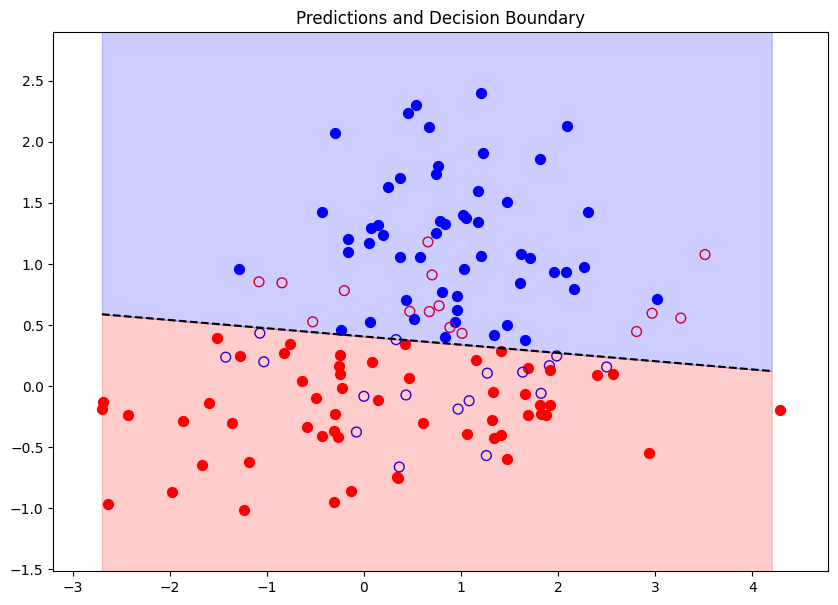

In [16]:
#plot results
plot_results(w, b, X, Y, y_preds, 'Predictions and Decision Boundary', color_code = True)

In the figure above the dashed line is the decision boundary of the logistic regression model. The model classifies everything above the decision boundary as category 2 and everything below as category 1. The solid circles represents the correctly classified data points while the open circles represents the incorrectly classified data points. (Solid red is category 1 classified as category 1 and open red is category 1 classified as category 2)

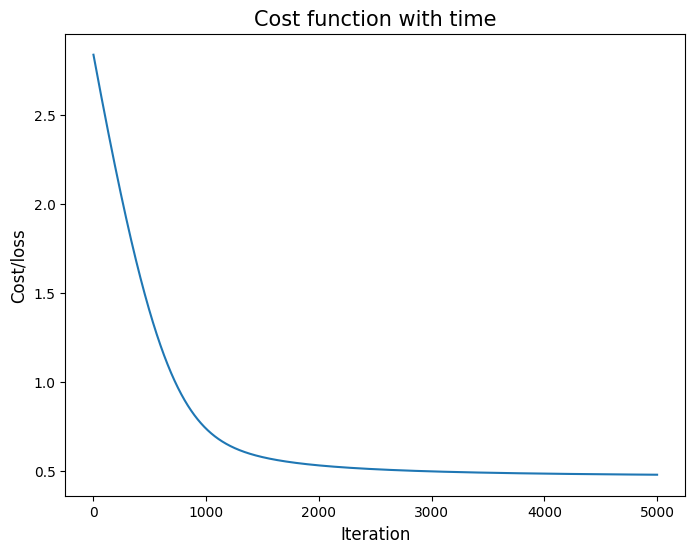

In [17]:
#cost
plt.figure(figsize = (8, 6))
plt.plot(costs)
plt.xlabel('Iteration', fontsize = 12)
plt.ylabel('Cost/loss', fontsize = 12)
plt.title('Cost function with time', fontsize = 15)
plt.show()

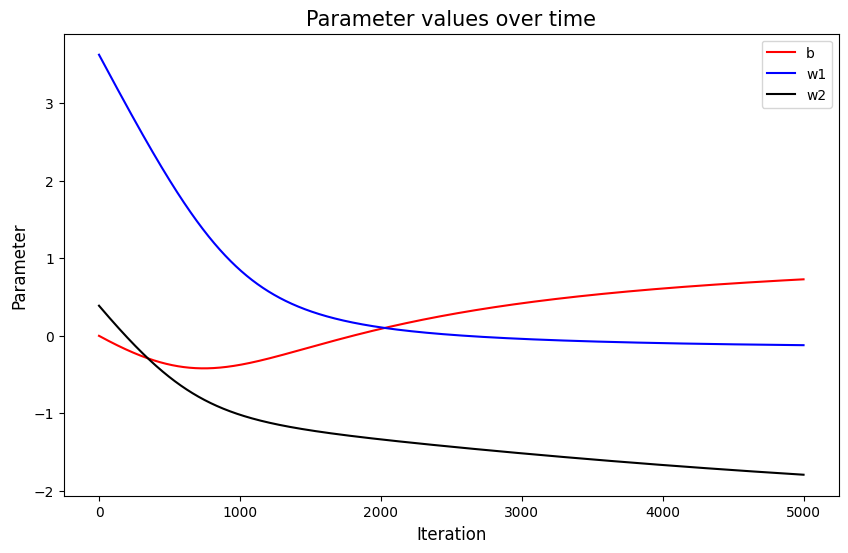

In [18]:
#plot the parameters with loss
plt.figure(figsize = (10, 6))
plt.plot(constant, color = 'r', label = 'b')
plt.plot(w1, color = 'b', label = 'w1')
plt.plot(w2, color = 'k', label = 'w2')
plt.xlabel('Iteration', fontsize = 12)
plt.ylabel('Parameter', fontsize = 12)
plt.title('Parameter values over time', fontsize = 15)
plt.legend()
plt.show()


**Logistic Regression using maximum likelihood estimation**

Here we are using another approach to find the best fitting parameters for our example above. This method is called the maximum likelihood estimation.

First we will create a function to calculate the cost. The function will take in the 3 parameters we are trying to optimize, the X values and the Y values.

In [19]:
#create a function to calculate the cost
def negative_log_likelihood(par, X, Y):
    
    #calculate the sigmoid
    Z = X[:, 0] * par[0] + X[:, 1] * par[1] + par[2]
    
    #cumulative probability distribution
    Y_pred = sigmoid(Z)
    
    #negative log likelihood
    nll = np.sum(-Y * np.log(Y_pred) - (1 - Y) * np.log(1 - Y_pred))
    
    return nll

Next we will use the python's built in fmin function to find the parameters that minimizes the loss value.

In [20]:
#use fmin to find the optimal values
params = opt.fmin(negative_log_likelihood, x0 = [2, 2, 0], args = (X, Y))
params = np.round(params, 4)

Optimization terminated successfully.
         Current function value: 65.669531
         Iterations: 200
         Function evaluations: 358


In [21]:
#print params
print('Values obtained by maximum likelihood estimation: \n W1: {} \n W2: {} \n b: {}'.format(params[0], params[1], params[2]))

Values obtained by maximum likelihood estimation: 
 W1: -0.1603 
 W2: -2.3603 
 b: 1.0788


Above are the values obtained by our maximum likelihood estimator. Now we can use them to find our predictions and find the prediction accuracy.

In [22]:
#get y predictions
y_preds = predict(params[:2], params[2], X, Y)

Prediction accuracy is 76.0  %


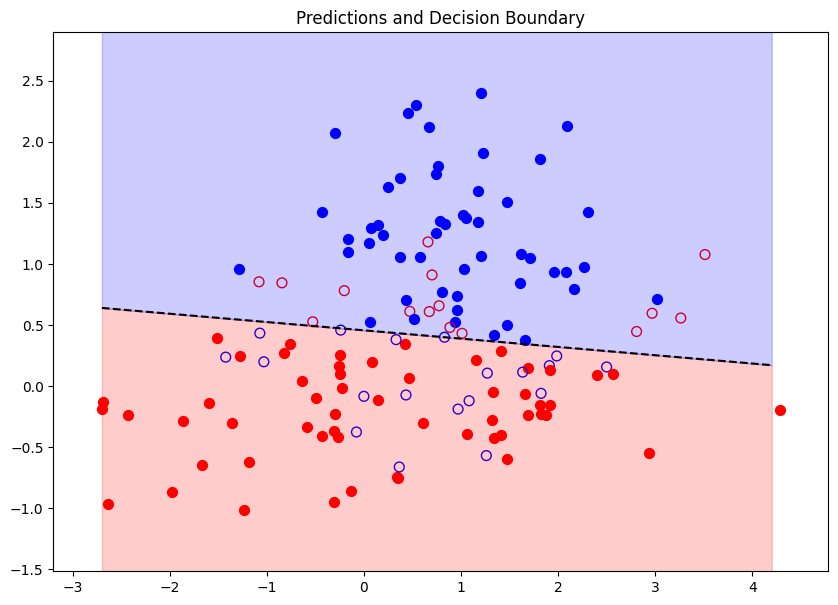

In [23]:
#plot the results
plot_results(params[:2], params[2], X, Y, y_preds, 'Predictions and Decision Boundary', color_code = True)

We get a similar prediction accuracy from our maximum likelihood estimator. We can also check the plot and see that the decision boundary is pretty much the same as before. 